# Grafazo

### Qué va a analizar nuestro grafo?

Analizar "camadas" de gente -> cursaron juntos y les fue parecido en la facu

### Qué queremos responder?

Con quien puedo hacer trabajos prácticos?

### Cómo es el grafo?

- Nodos: usuarios
- Aristas: cursar misma materia mismo cuatri
- Peso: correlacion entre notas(???)

### Ejemplo de conexion:

X y yo cursamos ...

In [ ]:
import pandas as pd

df = pd.read_pickle('fiuba-map-data.pickle')
df.sample(3)

Padron      Carrera Orientacion Final de Carrera materia_id  \
21323  42116191  informatica         NaN              NaN      61.03   
21324  42116191  informatica         NaN              NaN      62.01   
21325  42116191  informatica         NaN              NaN      75.40   

       materia_nota  materia_cuatrimestre  aplazos optativas  
21323           0.0                   NaN      NaN       NaN  
21324           0.0                   NaN      NaN       NaN  
21325           0.0                   NaN      NaN       NaN

In [ ]:
df_nodes_metadata = df[df.columns & ["Padron", "Carrera", "aplazos", "optativas", "checkboxes"]]
df_nodes_metadata = df_nodes_metadata[df_nodes_metadata["aplazos"].notnull() | df_nodes_metadata["optativas"].notnull()]
df_nodes_metadata = df_nodes_metadata.groupby(["Padron", "Carrera"], as_index=False).first()

df_nodes = df[["Padron", "Carrera", "Orientacion", "Final de Carrera"]]
df_nodes = df_nodes.drop_duplicates()
df_nodes = df_nodes.merge(df_nodes_metadata, how="outer")
df_nodes.set_index("Padron", inplace=True)
display(df_nodes.dropna().tail(3))

from itertools import combinations
df_edges = (df[df['materia_cuatrimestre'].notnull()]
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

df_edges = df_edges.reset_index()
df_edges[['src', 'dst']] = df_edges['Usuarios'].tolist()
df_edges[['src_padron', 'src_nota']] = df_edges['src'].tolist()
df_edges[['dst_padron', 'dst_nota']] = df_edges['dst'].tolist()
df_edges = df_edges[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]
display(df_edges.dropna().tail(3))

/tmp/ipykernel_130275/185306324.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df_nodes_metadata = df[df.columns & ["Padron", "Carrera", "aplazos", "optativas", "checkboxes"]]


Carrera Orientacion Final de Carrera  aplazos optativas
Padron                                                                
444111222  informatica         NaN              NaN      NaN       NaN
101805     informatica         NaN              NaN      NaN       NaN
42116191   informatica         NaN              NaN      NaN       NaN

/tmp/ipykernel_130275/185306324.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


src_padron dst_padron  materia_cuatrimestre materia_id src_nota  \
136983     105525   22081998                2025.0      78.xx     -2.0   
136984      99248   22081998                2025.0      78.xx     -2.0   
136985     104541    108215a                2027.0      78.xx     -2.0   

       dst_nota  
136983     -2.0  
136984     -2.0  
136985     -2.0

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(df_edges, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

nx.set_node_attributes(G, df_nodes.to_dict('index'))
print(G)

MultiGraph with 412 nodes and 136986 edges


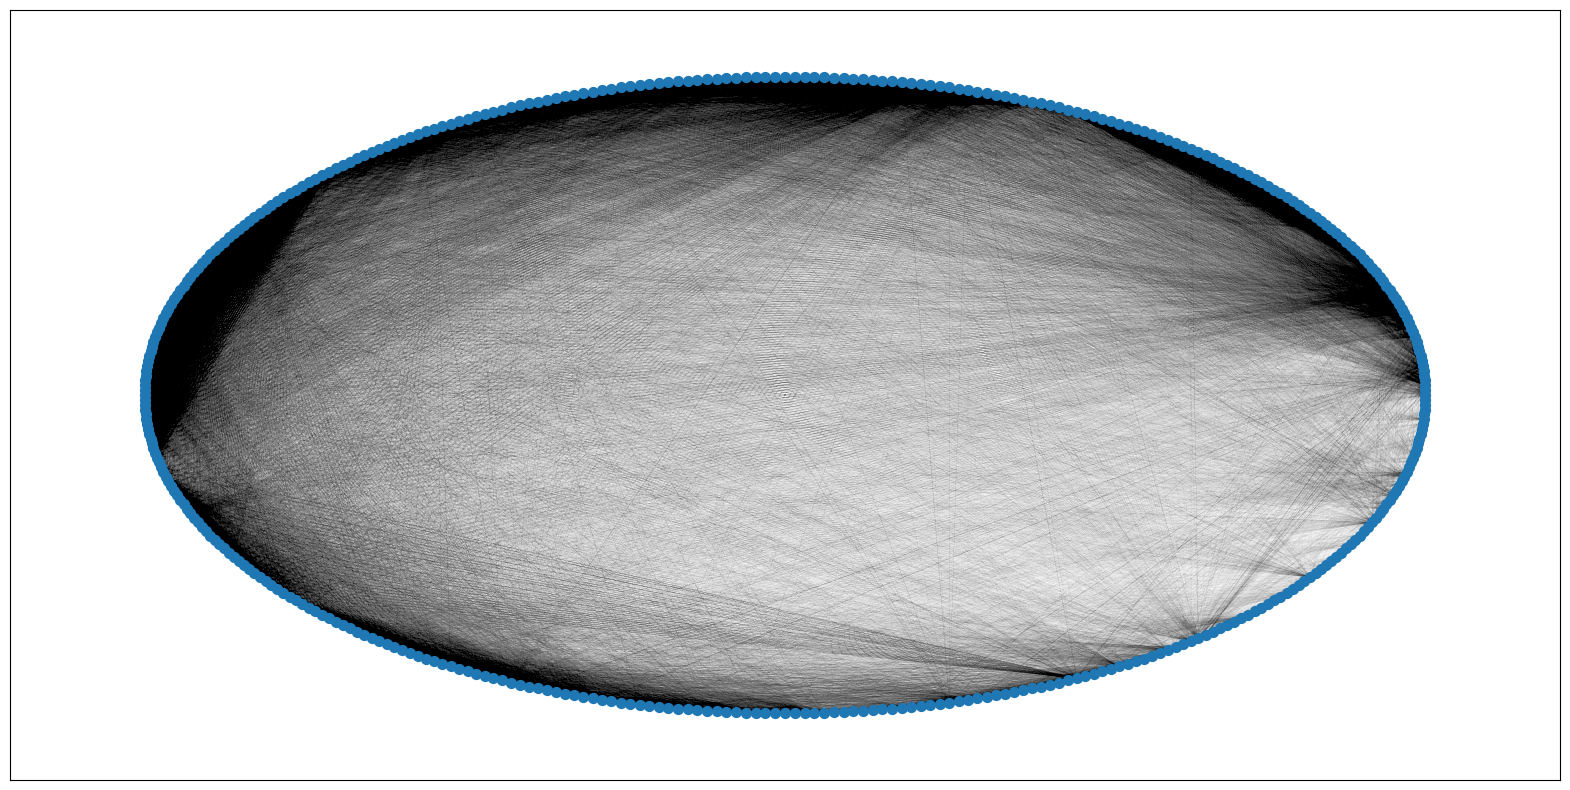

In [ ]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005, node_size=50, with_labels=False)

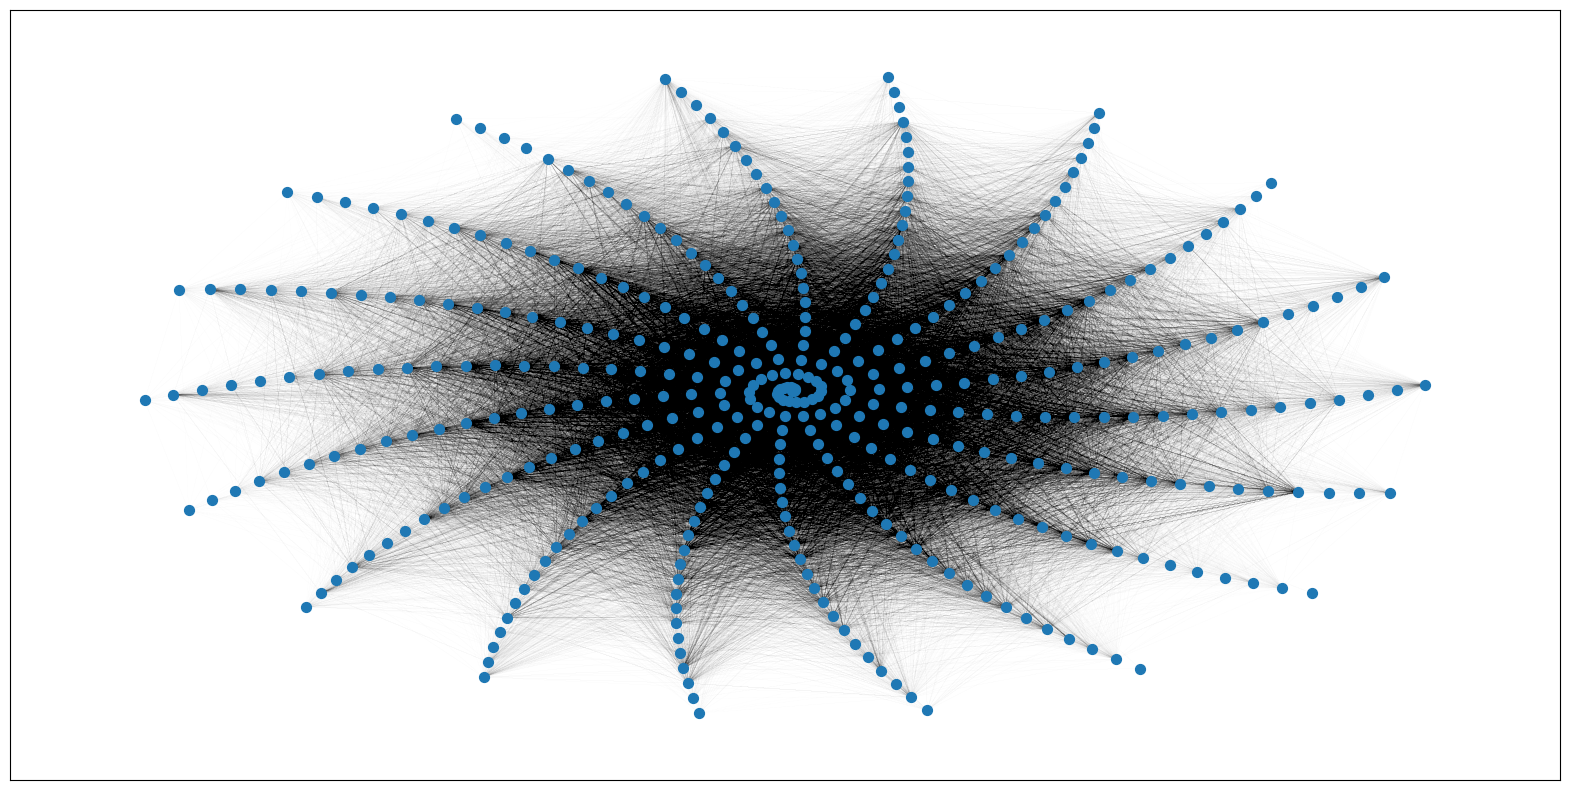

In [ ]:
# Again!
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.spiral_layout(G), width=0.005, node_size=50, with_labels=False)

In [ ]:
# # Solo como demo: ahora veamos el grafo, pero dibujemos todas las aristas
# # Robadisimo de: https://stackoverflow.com/a/60638452
# pos = nx.random_layout(G)
# nx.draw_networkx_nodes(G, pos)
# ax = plt.gca()
# for e in G.edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="-", color="0.5",
#                                 connectionstyle="arc3,rad=rr".replace('rr',str(0.3*e[2]))),
#                 )
# plt.axis('off')
# plt.show()

## Stats generales del grafo

In [ ]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


  El diámetro de la red: 4
  El grado promedio de la red: 664.98
  TODO: Los allegados promedio de la red: 
  Puentes globales: []



## Comunidades

In [ ]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

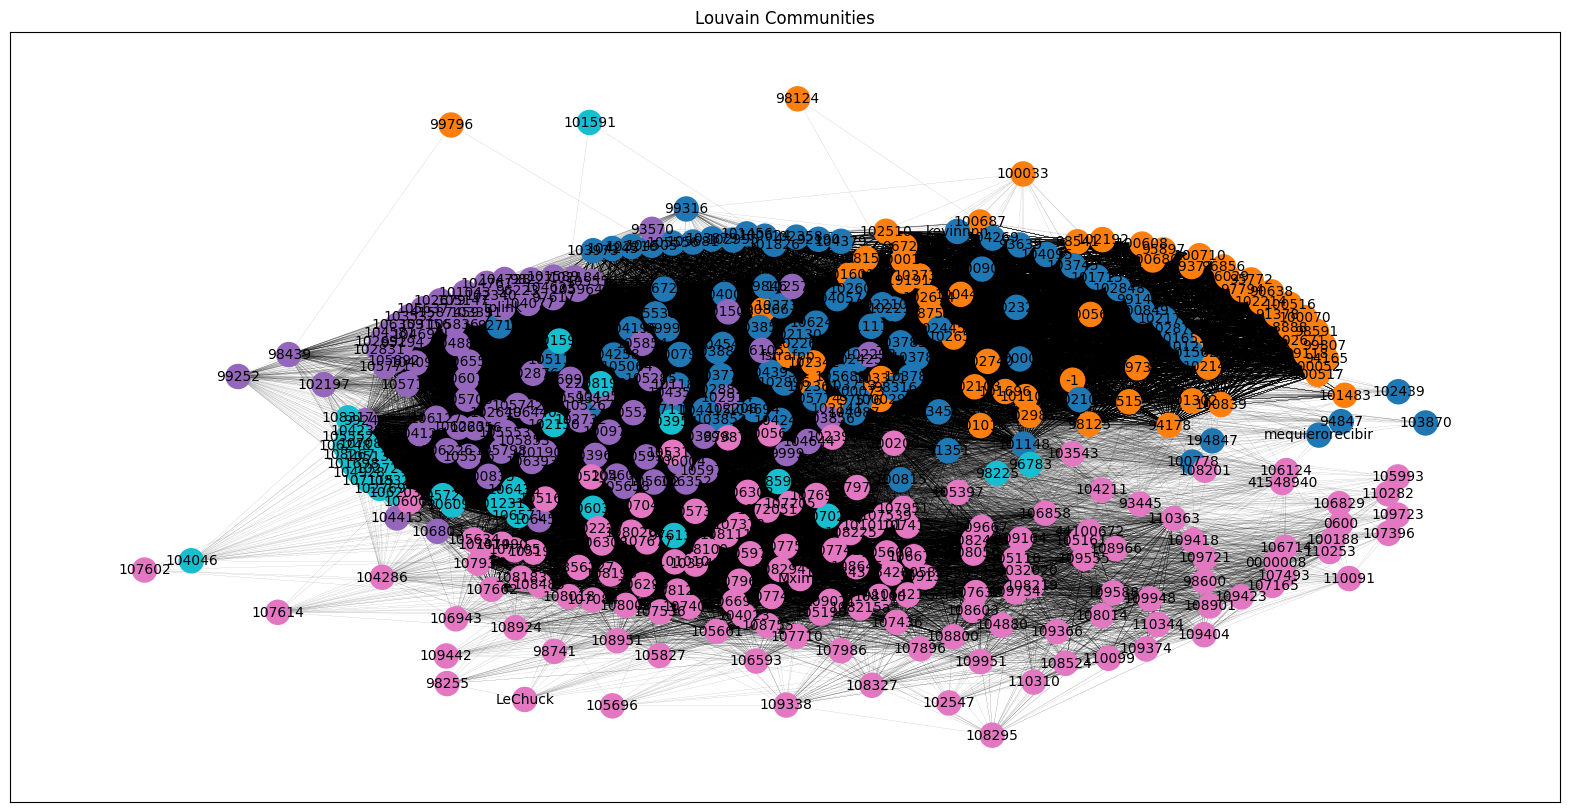

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
random.seed(42)

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

### Evaluación de comunidades por "generación"
¿Existe correlación entre la distribución de padrones y la comunidad? De tal forma que las comunidades sean por camadas o "generacionales"

In [ ]:
louvain_padrones = []
for i, comunidad in enumerate(louvain):
    for padron in comunidad:
        louvain_padrones.append((padron, i))
df_comunidades = pd.DataFrame(louvain_padrones, columns=["padron", "comunidad"])
df_comunidades["comunidad"].value_counts()

4    143
1     88
2     86
0     64
3     31
Name: comunidad, dtype: int64

In [ ]:
import seaborn as sns

# len patch for overflow
df = df_comunidades[(df_comunidades['padron'].str.isdigit()) & (df_comunidades["padron"].str.len() < 10)].copy()
df["padron"] = df["padron"].astype(int)

# remove outliers by percentiles, stolen from https://stackoverflow.com/a/59366409
Q1 = df["padron"].quantile(0.10)
Q3 = df["padron"].quantile(0.90)
IQR = Q3 - Q1
df_comunidades = df[~((df["padron"] < (Q1 - 1.5 * IQR)) |(df["padron"] > (Q3 + 1.5 * IQR)))]

Se puede observar una mínima correlación considerando el intervalo más frecuente de cada comunidad

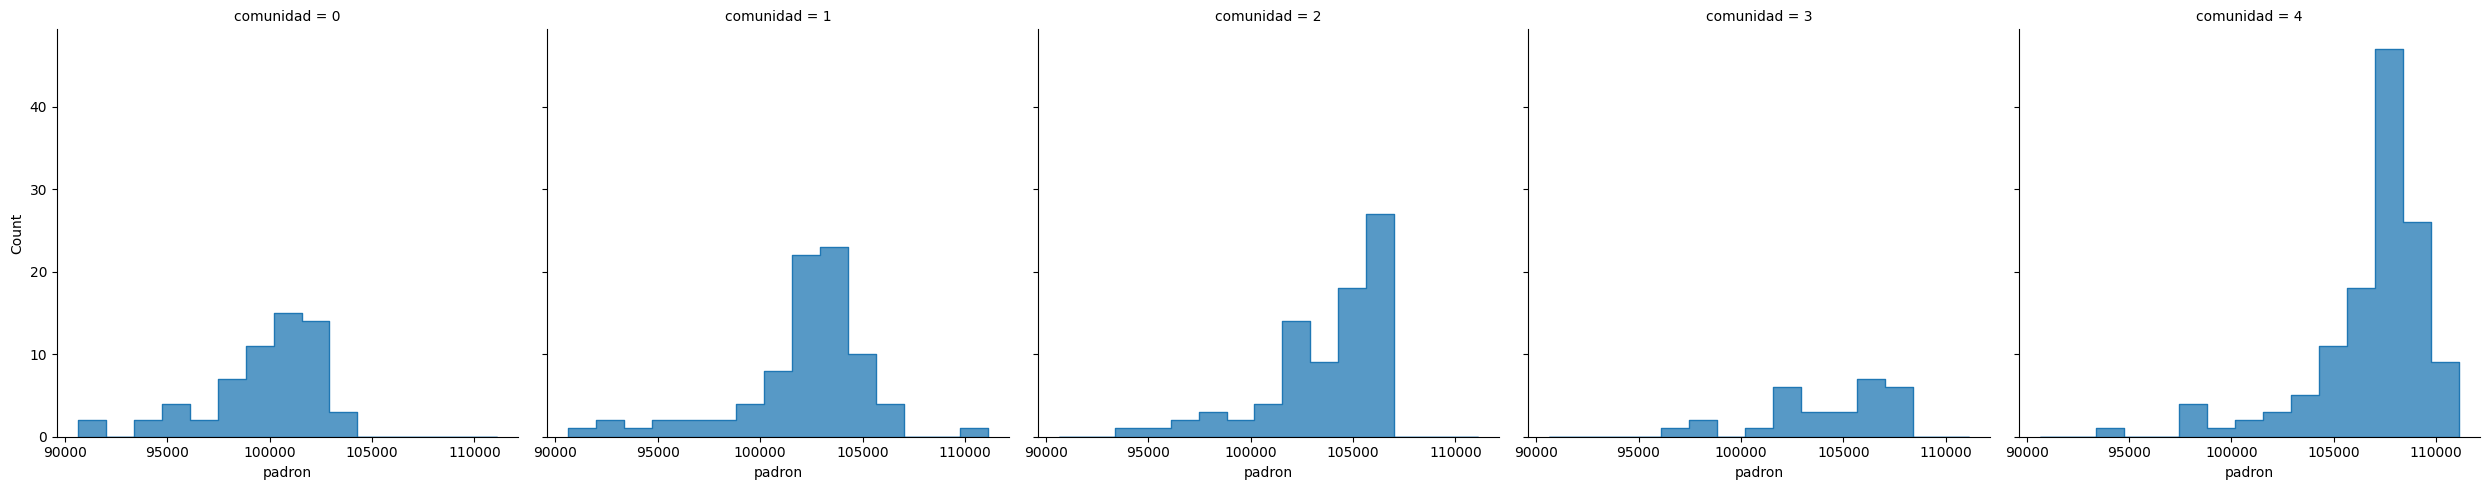

In [ ]:
# TODO: display as rows instead of columns, perhaps?
# TODO: play with the "stat" parameter. another interesting one is the "density" parameter
g = sns.displot(
    df_comunidades,
    x="padron",
    col="comunidad",
    element="step",
    stat="count",
    common_norm=False,
)

### Materias y cuatrimestres en común
Se puede aproximar a una mejor noción de _camada_ que simplemente tomando el padrón, tomando el conjunto de materias/cuatrimestre más populares por comunidad.

Las comunidades considerando dicha métrica, se observan personas que:

- Entraron a la facultad en el 2019c1
- Cursaron Taller de Programación en el 2020c1
- Entraron a la facultad en el 2020c1
- Tienen planificado hacer Base de Datos y Legislación en el 2023c1 (comunidad más chica)
- Entraron a la facultad en el 2021c1

In [ ]:
df = df_comunidades.copy()
df['padron'] = df['padron'].astype(str)
df_src = pd.merge(df_edges, df, left_on='src_padron', right_on='padron')
df_dst = pd.merge(df_edges, df, left_on='dst_padron', right_on='padron')
(
    pd
        .concat([df_src, df_dst])
        .groupby(['comunidad', 'materia_cuatrimestre', 'materia_id'])
        .agg(count=('src_padron', 'count'))
        .sort_values('count', ascending=False)
        .reset_index()
        .groupby('comunidad')   # obtener top 3 materias/cuatrimestres por comunidad
        .head(3)
        .sort_values(['comunidad', 'count'])
)

comunidad  materia_cuatrimestre materia_id  count
25          0                2019.0      62.03   2112
23          0                2020.0      75.42   2160
24          0                2019.5      66.70   2160
19          1                2019.0      75.40   2544
14          1                2019.0      61.03   2646
12          1                2019.0      62.01   2964
2           2                2020.5      75.41   3960
1           2                2020.0      61.03   3965
0           2                2020.0      75.40   4347
63          3                2022.0      75.08   1058
62          3                2023.0      75.43   1104
49          3                2023.0      71.40   1560
53          4                2023.0      75.09   1353
46          4                2021.0      75.40   1716
45          4                2021.5      75.41   1748

## Subcomunidades

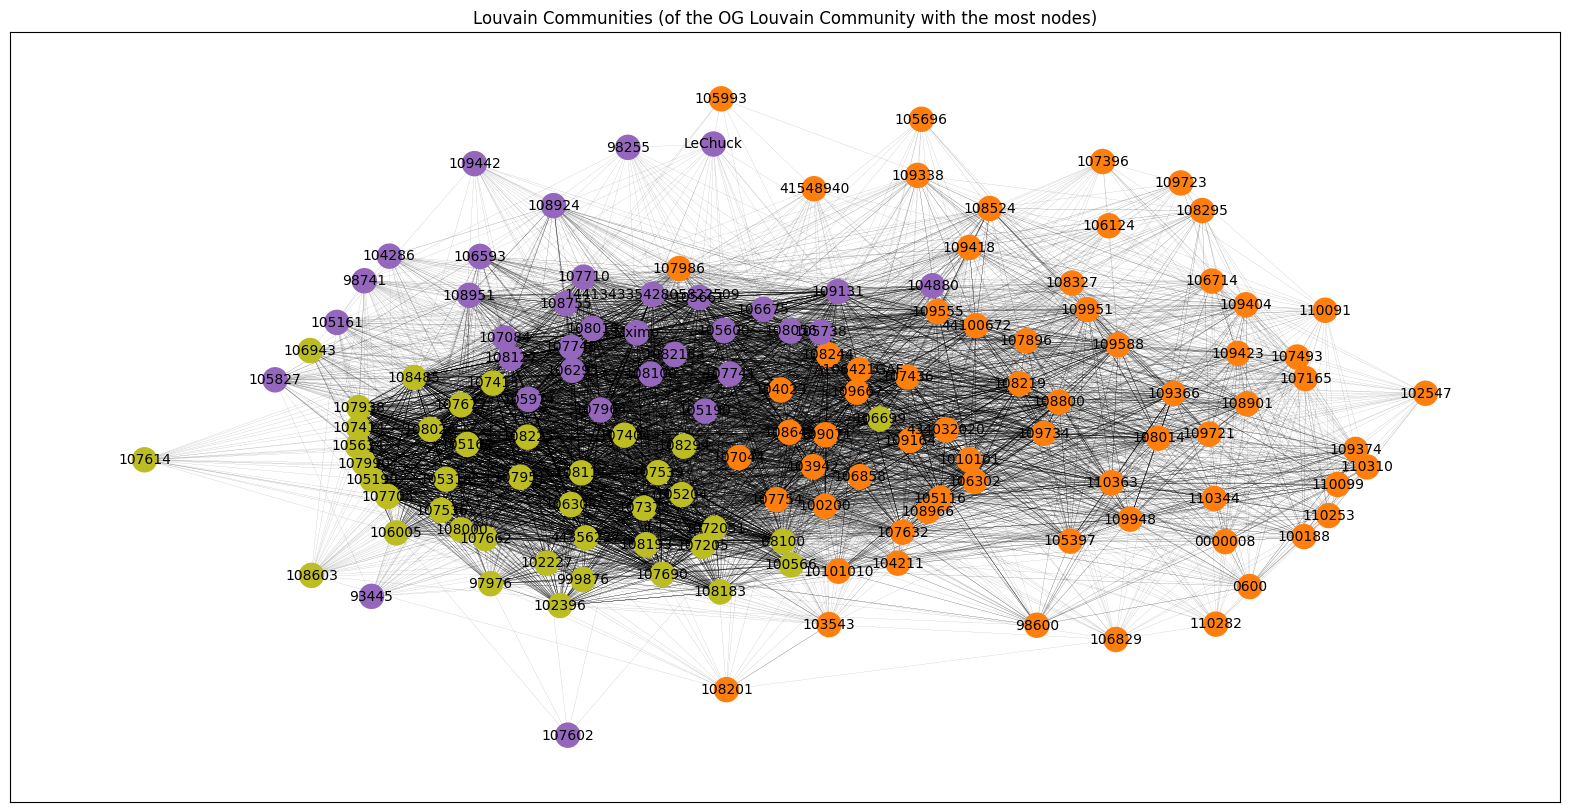

In [ ]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [ ]:
subnetwork_louvain

[{'100566',
  '102227',
  '102396',
  '105167',
  '105199',
  '105204',
  '105318',
  '105634',
  '106005',
  '106308',
  '106699',
  '106943',
  '107205',
  '1072051',
  '107378',
  '107404',
  '107413',
  '107414',
  '107536',
  '107539',
  '107614',
  '107662',
  '107677',
  '107690',
  '107705',
  '107938',
  '107951',
  '107990',
  '108000',
  '108026',
  '108111',
  '108183',
  '108193',
  '108225',
  '108294',
  '108485',
  '108603',
  '44356227',
  '68100',
  '97976',
  '999876'},
 {'0000008',
  '0600',
  '100188',
  '100200',
  '1010101',
  '10101010',
  '102547',
  '103543',
  '103942',
  '104023',
  '104211',
  '105116',
  '105397',
  '105696',
  '105993',
  '106124',
  '106302',
  '106714',
  '106829',
  '106858',
  '107044',
  '107165',
  '107396',
  '107436',
  '107493',
  '107632',
  '107754',
  '107896',
  '107986',
  '108014',
  '108201',
  '108219',
  '108244',
  '108295',
  '108327',
  '108524',
  '108645',
  '108800',
  '108901',
  '108966',
  '109071',
  '109164',


In [ ]:
# todo: usar graphrole y rolx

In [ ]:
# todo: ejercicio 5 de parcialito 3

In [ ]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [ ]:
# - Los 3 notebooks de grafos hacen exactamente el mismo analisis, pero con distintas conclusiones
# - Cada notebook de grafo devuelve un __algo__ que sea util y valioso para el usuario (despues vemos como se lo proveemos)
#   y la respuesta puede ser o de comunidad o de roles, hay que ver que es lo adecuado.